In [4]:
# DO NOT CHANGE

import torch
from PIL import Image
from IPython import display

import pandas as pd
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', weights='MobileNet_V2_Weights.DEFAULT', verbose=False)

# Put model in evaluation mode
model.eval()

# put the model on a GPU if available, otherwise CPU
model.to(device);

# Define the transforms for preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256x256
    transforms.CenterCrop(224),  # Crop the image to 224x224 about the center
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # Normalize the image with the ImageNet dataset mean values
        std=[0.229, 0.224, 0.225]  # Normalize the image with the ImageNet dataset standard deviation values
    )
]);

unnormalize = transforms.Normalize(
   mean= [-m/s for m, s in zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])],
   std= [1/s for s in [0.229, 0.224, 0.225]]
)

with open("../data/labels.txt", 'r') as f:
    labels = [label.strip() for label in f.readlines()]

img = Image.open("./basketball.jpg")
img_tensor = preprocess(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

img_tensor = preprocess(img).unsqueeze(0).to(device)

# move sample to the right device
img_tensor = img_tensor.to(device)

with torch.no_grad():
    output = model(img_tensor)
    
y_original = output[0].argmax()

def adversarial_satisfactory(samples, target, clip_min, clip_max):
    samples = torch.clamp(samples, clip_min, clip_max)
    
    with torch.no_grad():
        preds = model(samples).argmax(dim=1)
    
    # any other class
    result = preds != target
    return result

clip_min = -2
clip_max = +2

# randomly seed the generator
generator = torch.Generator().manual_seed(0)

# now generate a misclassified sample; we'll give ourselves 10 tries
for _ in range(10):
    random_img = torch.FloatTensor(img_tensor.shape).uniform_(clip_min,clip_max, generator=generator).to(device)
    random_class = model(random_img).argmax()

    if adversarial_satisfactory(random_img, y_original, clip_min, clip_max):
        initial_sample = (random_img, y_original)

        print(f"Found misclassified image: {random_class}")
        break

threshold = 0.01 / torch.sqrt(torch.prod(torch.tensor(img_tensor.shape, dtype=torch.float).to(img_tensor.device)))

upper_bound, lower_bound = 1,0 

cuda
Found misclassified image: 92


In [5]:
distances = []
for i in range(100):
    boundary_adversarial_example = (1-upper_bound)*img_tensor + upper_bound*random_img
    distance = torch.norm(boundary_adversarial_example - img_tensor, p=2)
    distances.append(distance.item())
    midpoint = (upper_bound + lower_bound) / 2.0
    
    interpolated_sample = (1 - midpoint) * img_tensor + midpoint * random_img
    
    if adversarial_satisfactory(interpolated_sample, y_original, clip_min, clip_max):
        # the decision boundary lies between midpoint and lower
        upper_bound, lower_bound = midpoint, lower_bound
    else:
        # it's the other way
        upper_bound, lower_bound = upper_bound, midpoint
    
boundary_adversarial_example = (1-upper_bound)*img_tensor + upper_bound*random_img

Text(0, 0.5, 'Distance')

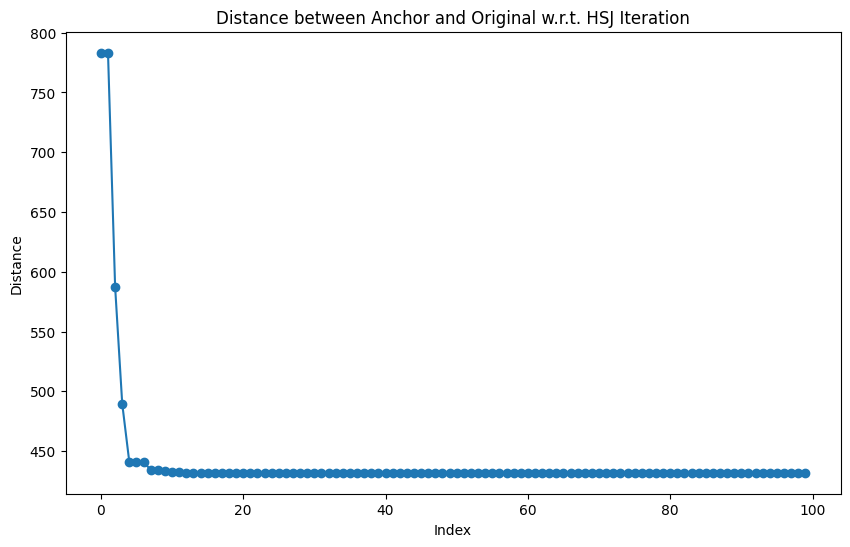

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(distances)), distances, marker='o')

plt.title('Distance between Anchor and Original w.r.t. HSJ Iteration')
plt.xlabel('Index')
plt.ylabel('Distance')